#### Note :
**Training scripts are python files present in this directory, results could be produced by executing main.py script. This notebook is just the summary of the project.**

## Semantic Segmentation
The goal of semantic segmentation is to classify each pixel in image to a pre-defined class. The various scales, occlusion and illumination changing of objects/stuff make it challenging to parsing each pixel.

In order to accomplish the task of scene segmentation effectively, we need to distinguish some confusing categories and take into
account objects with different appearance. For example, regions of ’field’ and ’grass’ are often indistinguishable, and
the objects of ’cars’ may often be affected by scales, occlusion and illumination. Therefore, it is necessary to enhance the discriminative ability of feature representations for pixel-level recognition

In [2]:
import numpy as np
import os
import sys
import cv2
from loader import *
from utils import load_model
from metric import runningScore
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader

### Cityscapes Dataset


The cityscapes dataset consists of high resolution images. 

It has 5,000 images captured from 50 different cities. Each image has 2048 × 1024 pixels, which have high quality pixel-level labels of 19 semantic classes. There are 2,979 images in training set, 500 images in validation set and 1,525 images in test set. We do not use coarse data in our experiments

In [29]:
# samples from the dataset
path = "../../cityscapes-semantic-segmentation/dataset/"

In [40]:
image = Image.open(os.path.join(path, "leftImg8bit/train/bremen/bremen_000100_000019_leftImg8bit.png"))
mask = Image.open(os.path.join(path, "gtFine/train/bremen/bremen_000100_000019_gtFine_instanceIds.png"))

print(f"Image size: {image.size}, mask size: {mask.size}")

Image size: (2048, 1024), mask size: (2048, 1024)


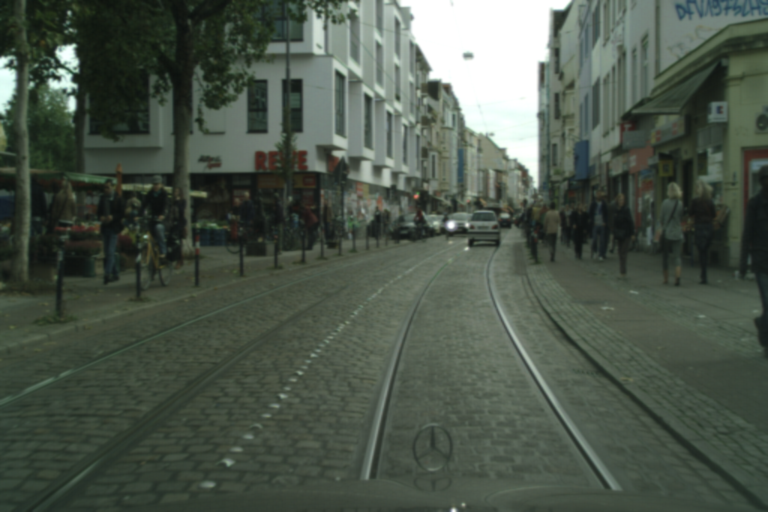

In [46]:
# resize the image
image = image.resize((768, 512), Image.BILINEAR)
image

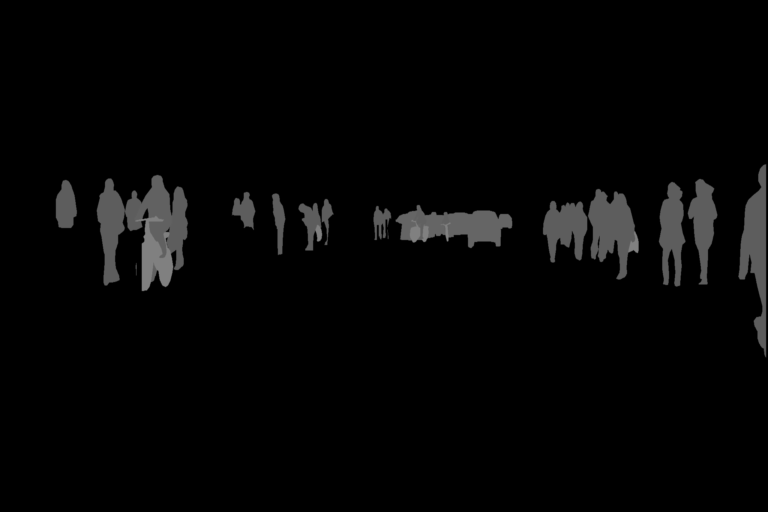

In [49]:
# resize the mask
mask = mask.resize((768, 512), Image.NEAREST)
mask

**Class distribution in the data**

In [55]:
names = [v for (k,v) in class_names.items() if mapping.get(k) != ignore_label] + ['background']
print("Class names : ", names)

Class names :  ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'background']


In [110]:
num_classes = 34

trainId_to_count = dict(zip(range(num_classes), np.zeros(num_classes, np.uint8)))
train_file_path = "dataset/train.txt"
with open(train_file_path, 'r') as file:
    paths = file.readlines()

mask_paths = []
for line in paths:
    mask_path = (line.split('\t')[1]).split('\n')[0]
    mask_paths.append(mask_path)


for step, label_img_path in enumerate(mask_paths):

    label_img = cv2.imread(f"{path}/{label_img_path}", -1)

    for trainId in range(num_classes):
        # count how many pixels in label_img which are of object class trainId:
        trainId_count = np.sum(np.equal(label_img, trainId))
        # add to the total count:
        trainId_to_count[trainId] += trainId_count
        
total_count = sum(trainId_to_count.values())
class_percent = [float(count)/float(total_count) for trainId, count in trainId_to_count.items()]

In [111]:
indices = [k for (k,v) in mapping.items() if v != ignore_label]
percent = np.array(class_percent)[indices] * 100
percent = percent.tolist() + [(100 - percent.sum())]

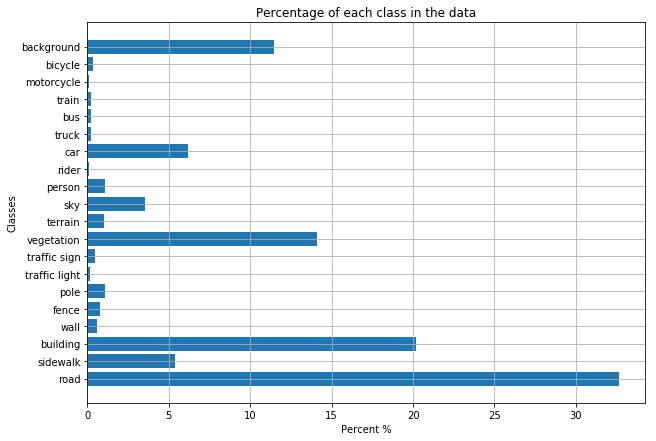

In [112]:
plt.figure(figsize=(10,7))
plt.barh(list(range(1,21)), percent)
plt.grid()
plt.yticks(list(range(1,21)), names)
plt.ylabel("Classes")
plt.xlabel("Percent %")
plt.title("Percentage of each class in the data")
plt.show()

This is the distribution of classes present in the data. 

As it can be seen that classes are very unbalanced in the data, which motivates the use of class weights while training. 
In such case, when a few classes dominates the data, model will learn to predict these classes often than others.
Class weights are helpful to assign importance to a class while calculating loss. We can control how important each class is, so usually more weight is assigned to less **frequent class** like `"pole, fence"` etc and less weight to **dominant class**

In [107]:
# calculate class weights
from utils import calculate_class_weights
class_weights = calculate_class_weights(path, 34, indices)

In [104]:
dict(zip(names, class_weights))

{'road': 3.362088928135997,
 'sidewalk': 14.031521298730318,
 'building': 4.986657918172686,
 'wall': 39.254403222891234,
 'fence': 36.5125971773311,
 'pole': 32.89620795239199,
 'traffic light': 46.286660134462245,
 'traffic sign': 40.69042748040039,
 'vegetation': 6.698241903441155,
 'terrain': 33.55545414377673,
 'sky': 18.487832644189325,
 'person': 32.97431249303082,
 'rider': 47.676506488107115,
 'car': 12.70028597336979,
 'truck': 45.20542136324199,
 'bus': 45.78372411642551,
 'train': 45.825290445040096,
 'motorcycle': 48.40614734589367,
 'bicycle': 42.75592219573717,
 'background': 7.912219457368151}

### Training Pipeline

Training pipeline consists of below steps:
1. Creating dataloaders by preprocessing images. 
2. Loss
3. Network architecture
4. Optimizer and scheduler
5. Hyperparameters

**1. Creating dataloaders by preprocessing images** <br>
For dataloading pipeline, we use randomcrop augmentation and random horizontal flip with 0.5 probability. <br>
The original image size is too big for training this is why we take out the random crop of size 704 for training purpose.
This is followed by normalizing the images.

**2. Loss**<br>
As we saw above that data is highly unbalanced, therefore we are using weighted cross entropy which weight the contribution of each class in loss calculation and helps the network to learn less occuring classes as well.


**3. Network Architecture** <br>
For network, we are using Unet architecture, this network consists of encode and decoder. 
In encoder at each level feature maps are doubled and their spatial size is halved, there are such 5 levels in encoder and decoder takes the output of final layer of encoder and upsample it using transposed convolutions. 

**4. Optimizer and Scheduler**<br>
SGD with momentum, weight decay is also used to avoid overfitting and we are also using learning rate scheduler which decay the learning rate at each step.  

**5. Hyperparameters** <br>
The other hyperparameters used for training are
```
learning rate = 0.01
batch size = 12
epochs = 200
momentum = 0.9
weight_decay = 0.0001

```

#### Training Results

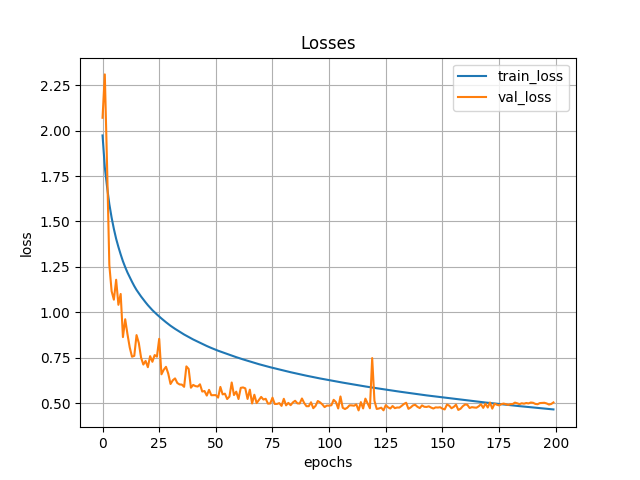

In [105]:
## loss plot
path = "exp_unet3/output/plots/"
Image.open(path + "loss.png")

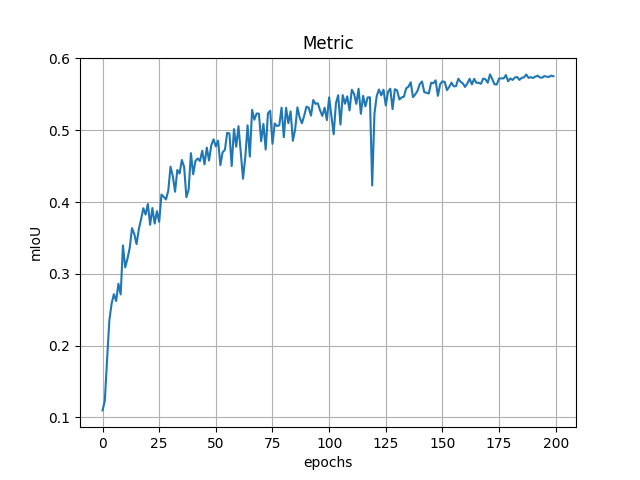

In [106]:
## metric plot
Image.open(path + "metric.png")

**We used mIoU as an evaluation metric which is averaged over each classes IoU (Intersection over Union). <br>
The above plot shows the mIoU calculated over validation set which achieves accuracy of 0.576**

#### Predictions

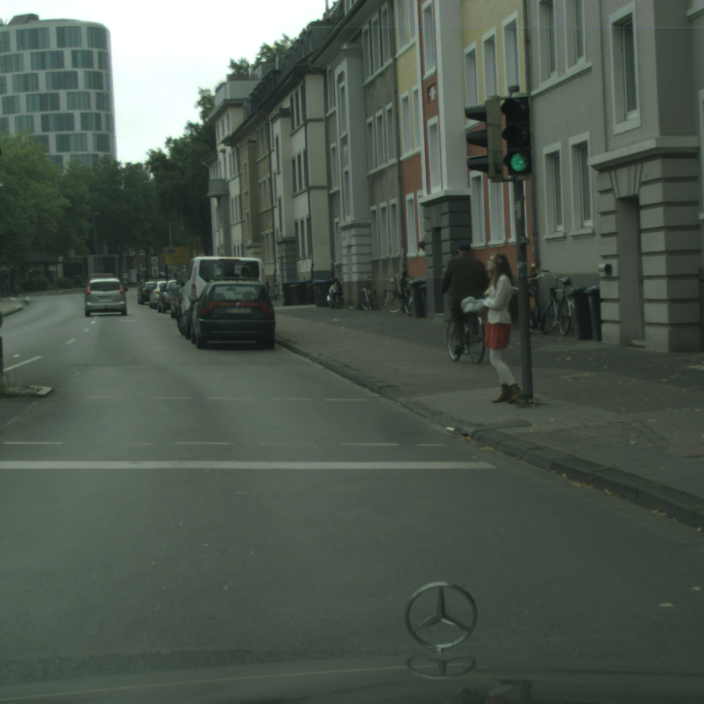

In [4]:
# this is the actual image from 190 epoch state of the network
Image.open("images/im_epoch_190.png")

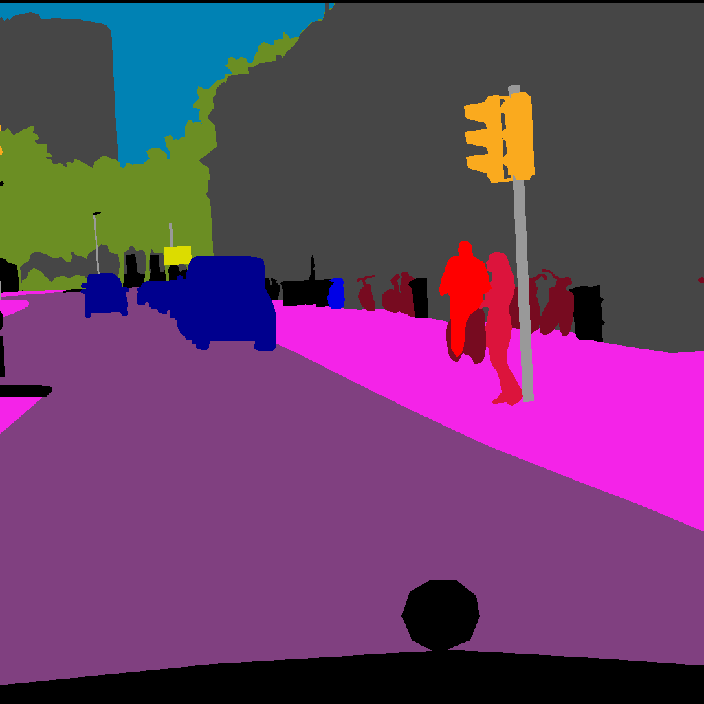

In [5]:
# this is the actual ground truth for the image 
Image.open("images/mask_epoch_190.png")

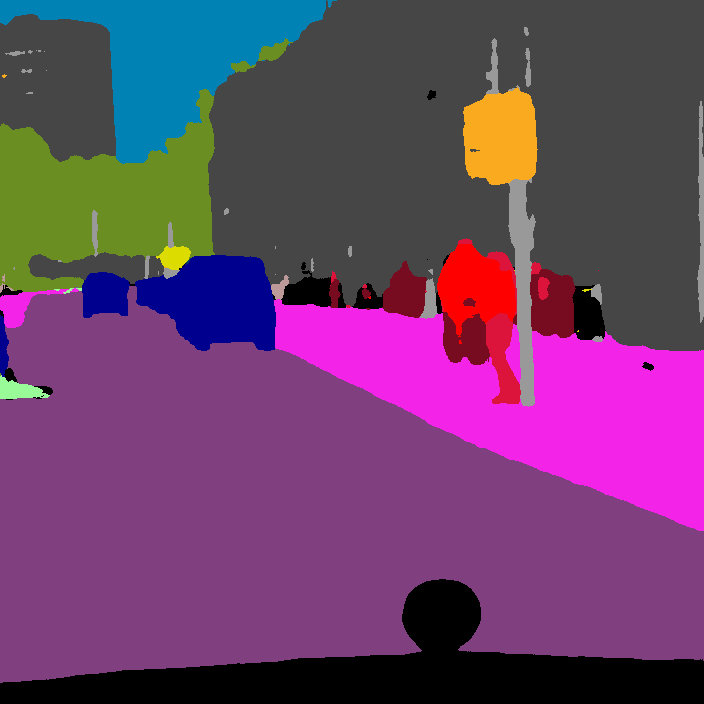

In [6]:
# this is the predicted mask from the network

Image.open("images/pred_epoch_190.png")